In [1]:
#Install necessary library
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
#read dataset 1
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [6]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [7]:
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [6]:
#read dataset 2
df_val = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet')

In [7]:
df_train = df

In [8]:
# Create 'PU_DO' column
df_train['PU_DO'] = df_train['PULocationID'].astype(str) + '_' + df_train['DOLocationID'].astype(str)
df_val['PU_DO'] = df_val['PULocationID'].astype(str) + '_' + df_val['DOLocationID'].astype(str)

In [9]:
# Define categorical and numerical features
categorical = ['PU_DO']
numerical = ['trip_distance']
features = categorical + numerical

In [10]:
#create/format duration column
df_val['duration'] = df_val.tpep_dropoff_datetime - df_val.tpep_pickup_datetime

df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)

In [11]:
#create/format duration column
df_train['duration'] = df_train.tpep_dropoff_datetime - df_train.tpep_pickup_datetime

df_train.duration = df_train.duration.apply(lambda td: td.total_seconds() / 60)

In [14]:
df_train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
count,2.964624e+06,2.824462e+06,2.964624e+06,2.824462e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06,2.964624e+06
mean,1.754204e+00,1.339281e+00,3.652169e+00,2.069359e+00,1.660179e+02,1.651167e+02,1.161271e+00,1.817506e+01,1.451598e+00,4.833823e-01,3.335870e+00,5.270212e-01,9.756319e-01,2.680150e+01,2.256122e+00,1.411611e-01,1.561295e+01
std,4.325902e-01,8.502817e-01,2.254626e+02,9.823219e+00,6.362391e+01,6.931535e+01,5.808686e-01,1.894955e+01,1.804102e+00,1.177600e-01,3.896551e+00,2.128310e+00,2.183645e-01,2.338558e+01,8.232747e-01,4.876239e-01,3.485105e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-8.000000e+01,-1.000000e+00,-9.000000e+02,-2.500000e+00,-1.750000e+00,-1.356667e+01
25%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00,7.150000e+00
50%,2.000000e+00,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.700000e+00,0.000000e+00,1.000000e+00,2.010000e+01,2.500000e+00,0.000000e+00,1.163333e+01
75%,2.000000e+00,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.856000e+01,2.500000e+00,0.000000e+00,1.868333e+01
max,6.000000e+00,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,1.425000e+01,4.000000e+00,4.280000e+02,1.159200e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00,9.455400e+03


In [12]:
# Filter out rows with missing values and outliers in the target variable 'duration'
duration_filter = (df_train['duration'] >= 1) & (df_train['duration'] <= 60)
df_train = df_train[duration_filter]

duration_filter = (df_val['duration'] >= 1) & (df_val['duration'] <= 60)
df_val = df_val[duration_filter]

In [13]:
# Convert DataFrame to list of dictionaries
train_dicts = df_train[features + ['duration']].to_dict(orient='records')
val_dicts = df_val[features + ['duration']].to_dict(orient='records')

# Fit the DictVectorizer
dv = DictVectorizer()
dv.fit(train_dicts)

# Get the feature matrix
X_train = dv.transform(train_dicts)
X_val = dv.transform(val_dicts)

# Separate the target variable
y_train = df_train['duration'].values
y_val = df_val['duration'].values

In [32]:
#number of columns in the feature matrix
X_train.shape[1]

24017

In [17]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [18]:
# Predict on the training set
y_train_pred = lr.predict(X_train)

# Predict on the validation set
y_val_pred = lr.predict(X_val)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


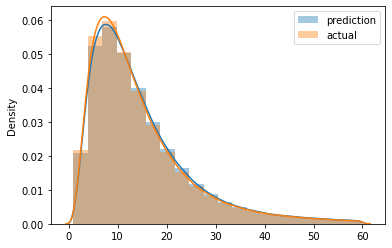

In [19]:
plt.figure(figsize = (6,4))
sns.distplot(y_val_pred, label='prediction', bins = 20)
sns.distplot(y_train_pred, label='actual', bins = 20)

plt.legend()
plt.show()

In [20]:
# Calculate and print the RMSE on the training set
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'Root Mean Squared Error (Training): {rmse_train}')

Root Mean Squared Error (Training): 4.907374564656862e-06


In [21]:
# Calculate and print the RMSE on the validation set
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
print(f'Root Mean Squared Error (Validation): {rmse_val}')

Root Mean Squared Error (Validation): 4.845725152525976e-06


In [14]:
# Train Lasso Regression model
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

Lasso(alpha=0.01)

In [15]:
# Predict on the validation set
y_val_pred = lr.predict(X_val)

In [20]:
# Calculate and print the RMSE on the validation set
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
print(f'Root Mean Squared Error (Validation): {rmse_val}')

Root Mean Squared Error (Validation): 0.0009933460063945604


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


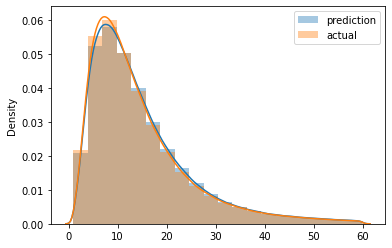

In [21]:
plt.figure(figsize = (6,4))
sns.distplot(y_val_pred, label='prediction', bins = 20)
sns.distplot(y_train, label='actual', bins = 20)

plt.legend()
plt.show()